**Empezamos**

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers as lys
import random
import string
import re


**Configuración**

In [ ]:
num_samples = 120000  # Número de muestra para entrenar.
data_path = "./fra.txt"  # Path al archivo txt.



In [ ]:
batch_size = 64  # Batch size para el entrenamiento.
epochs = 100  # Número de epochs a entrenar.
latent_dim = 128  # Dimensionalidad latente del espacio codificado.
output_dim = 64

**Preparamos la data**

In [ ]:
# Vectorizamos la data.
input_texts = []
target_texts = []
input_ = []
tar_ = []
input_characters = set()
target_characters = set()

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
    for _ in range(5):
        input_text, target_text, _ = line.split("\t")
        input_text = input_text.lower()
        input_text = re.sub(r'[^a-zA-Z ]+', '', input_text)
        target_text = "\t" + input_text + "\n"
        for i in range(np.random.choice(np.arange(0, 2), p=[0.1, 0.9])):
            input_text = input_text.replace(random.choice(list(input_text)), random.choice(string.ascii_letters))

        input_texts.append(input_text.lower())
        target_texts.append(target_text)
        for char in input_text.lower():
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data se encuentra adelante de decoder_input_data por un timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data estará adelantado por un timestep
            # any no incluirá el caracter inicial.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1:, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0



Number of samples: 600000
Number of unique input tokens: 27
Number of unique output tokens: 29
Max sequence length for inputs: 31
Max sequence length for outputs: 33


In [9]:
print(input_token_index)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


**Construímos el modelo**

In [10]:
# Definimos una secuencia de entrada y procesamos.
encoder_inputs = ks.Input(shape=(None, num_encoder_tokens))
encoder = lys.LSTM(latent_dim, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# Descartamos `encoder_outputs` y nos quedamos con los estados.
encoder_states = [state_h, state_c]

# Preparamos el decodificador, usando `encoder_states` como el estado inicial.
decoder_inputs = ks.Input(shape=(None, num_decoder_tokens))

# Preparamos nuestro decodificador para que retorne secuencias de salida completas,
# y para devolver estados internos también. No usamos los estados de retorno
# en el modelo de entrenamiento, pero los usaremos en inferencia.
decoder_lstm = lys.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = lys.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Definir el modelo que convertirá
# `encoder_input_data` y `decoder_input_data` en `decoder_target_data`
model = ks.Model([encoder_inputs, decoder_inputs], decoder_outputs)



**Entrenamos el modelo**

In [11]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [12]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=15,
    validation_split=0.2,
)
# Guardamos el modelo
model.save("auto.h5")

Epoch 1/15
7500/7500 [==============================] - 864s 115ms/step - loss: 1.2478 - accuracy: 0.6318 - val_loss: 1.2700 - val_accuracy: 0.6209
Epoch 2/15
7500/7500 [==============================] - 861s 115ms/step - loss: 0.8868 - accuracy: 0.7386 - val_loss: 1.1193 - val_accuracy: 0.6735
Epoch 3/15
7500/7500 [==============================] - 862s 115ms/step - loss: 0.7811 - accuracy: 0.7704 - val_loss: 1.0895 - val_accuracy: 0.6899
Epoch 4/15
7500/7500 [==============================] - 859s 114ms/step - loss: 0.7246 - accuracy: 0.7877 - val_loss: 1.0357 - val_accuracy: 0.7064
Epoch 5/15
7500/7500 [==============================] - 870s 116ms/step - loss: 0.6863 - accuracy: 0.7995 - val_loss: 1.0274 - val_accuracy: 0.7081
Epoch 6/15
7500/7500 [==============================] - 873s 116ms/step - loss: 0.6594 - accuracy: 0.8076 - val_loss: 0.9978 - val_accuracy: 0.7173
Epoch 7/15
7500/7500 [==============================] - 874s 117ms/step - loss: 0.6377 - accuracy: 0.8141 - val_

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 27)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 29)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        79872       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

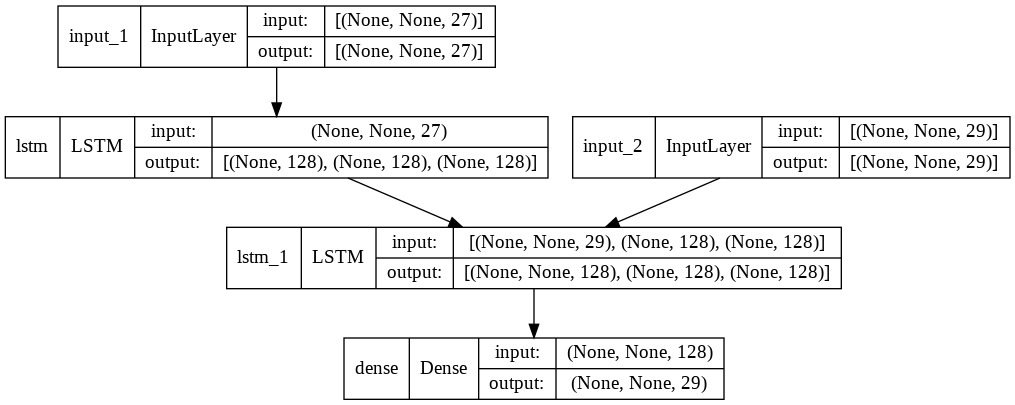

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

**Muestreo**

In [15]:
# Definimos los modelos de muestra
# Restauramos el modelo y construímos el encodificador y decodificador.
# model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = ks.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = ks.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = ks.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = ks.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Índice de token revertido para decodificar secuencias de vuelta a una forma que se pueda leer
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    # Codificamos el input como vectores de estado.
    states_value = encoder_model.predict(input_seq)

    # Generamos la secuencia target vacía de longitud 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Poblamos el primer caracter de la secuencia target con el caracter inicial.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Loop de muestra para un batch de secuencias
    # Para simplificar asumimos un batch de tamaño 1.
    stop_condition = False
    decoded_sentence_check = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Token de muestra
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence_check += sampled_char

        # Condición de salida: O llegamos a la máxima longitud
        # o encontramos un caracter que detenga el proceso.
        if sampled_char == "\n" or len(decoded_sentence_check) > max_decoder_seq_length:
            stop_condition = True

        # Actualizamos la secuencia target de longitud 1.
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Actualizamos los estados
        states_value = [h, c]
    return decoded_sentence_check

In [19]:
texto_prueba = "ygu mqst leave now"

encoder_test_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

for t, char in enumerate(texto_prueba):
    encoder_test_data[0, t, input_token_index[char]] = 1.0

decoded_sentence = decode_sequence(encoder_test_data)
print(decoded_sentence)

you must leave now

